# I saw this in the book

In [53]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras import layers
from tensorflow.keras import models

In [9]:
df = pd.read_csv("data/set.csv").drop(columns=['DateTime'])
df = df.reset_index()

In [72]:
class MultiModal(tf.keras.utils.Sequence):
    def __init__(self,
                 imageCol, targetCol,
                 tabularFeatures, oneHotFeatures,
                 imageDir, df: pd.DataFrame,
                 batchSize=8, trainSize=0.8):
        self.batchSize = batchSize
        self.imageDir = imageDir
        self.imagePaths = df[imageCol]
        self.targetCol = df[targetCol]
        self.tabular = df.drop(columns=[imageCol, targetCol])#[tabularFeatures]
        for feature in oneHotFeatures:
            self.tabular = self.tabular.join(pd.get_dummies(self.tabular[feature]))
            self.tabular.drop(feature, axis=1, inplace=True)
        
        self.dataSize = len(df)
        self.trainSize = round(self.dataSize * trainSize)
        
        dataIndices = np.array(df.index)
        self.trainInd = np.random.choice(dataIndices,
                                         size = self.trainSize)
        self.validInd = np.array([i for i in dataIndices if i not in self.trainInd])
    def __len__(self): 
        return self.trainSize // self.batchSize
    def __getitem__(self, index):
        images, tabulars, y = [], [], []
        for i in range(self.batchSize):
            currIndex = index * self.batchSize + i
            name = "{:04d}".format(self.imagePaths[currIndex])
            imagePath = f'{self.imageDir}/{name}.png'
            # image = cv2.resize(cv2.imread(imagePath), (100, 100))
            image = cv2.imread(imagePath)
            tabular = np.array(self.tabular.loc[currIndex])
            target = self.targetCol[currIndex]
            images.append(image)
            tabulars.append(tabular)
            y.append(target)
        return [np.stack(images), np.stack(tabulars)], np.stack(y)


In [73]:
data = MultiModal(imageCol='index', targetCol='PT08.S1(CO)', 
                  tabularFeatures=['PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'datetimestamp'],
                  oneHotFeatures=['datetimestamp'],
                  imageDir='imagesTML/textINimage/CO',
                  df=df
                 )

(8, 100, 100, 3)
(8, 8452)
(8,)
           0
0     1270.0
1      806.0
2     1739.0
3     1113.0
4       31.3
...      ...
8447   False
8448   False
8449   False
8450   False
8451   False

[8452 rows x 1 columns]


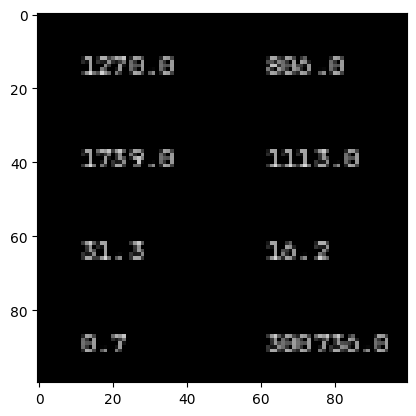

In [74]:
x, y = data.__getitem__(111)
print(x[0].shape)
print(x[1].shape)
print(y.shape)
print(pd.DataFrame(x[1][0]))
plt.imshow(x[0][0])
plt.show()

In [56]:
imgInput = layers.Input((100, 100, 3))
x = layers.Conv2D(8, (3, 3), activation='relu', padding='valid')(imgInput)
for filters in [8, 8, 16, 16, 32, 32]:
    x1 = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(x)
    x2 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x3a = layers.Conv2D(filters, (5, 5), activation='relu', padding='same')(x)
    x3b = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    add = layers.Add()([x1, x2, x3b])
    x = layers.MaxPooling2D((2, 2))(add)
flatten = layers.Flatten()(x)
imgDense1 = layers.Dense(64, activation='relu')(flatten)
imgDense2 = layers.Dense(32, activation='relu')(imgDense1)
imgOut = layers.Dense(16, activation='relu')(imgDense2)

tabularInput = layers.Input((8,))
tabDense1 = layers.Dense(16, activation='relu')(tabularInput)
tabDense2 = layers.Dense(16, activation='relu')(tabDense1)
tabOut = layers.Dense(16, activation='relu')(tabDense2)

concat = layers.Concatenate()([imgOut, tabOut])
dense1 = layers.Dense(16, activation='relu')(concat)
dense2 = layers.Dense(16, activation='relu')(dense1)
out = layers.Dense(1, activation='relu')(dense2)

model = models.Model(inputs = [imgInput, tabularInput],
                           outputs = out)

In [50]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse'])

history = model.fit(data, epochs = 100)

plt.figure(figsize=(10, 5), dpi=400)
plt.plot(history.history['loss'], color='red', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


ValueError: Invalid dtype: object

# Multi model with dataset

In [ ]:
class MultiModalDataset(tf.keras.utils.Sequence):
    
    def __init__(self,
                 imageCol, targetCol,
                 tabularFeatures, embeddingFeature,
                 imageDir, df: pd.DataFrame,
                 batchSize=8, trainSize=0.8):
        # there was the scale (i dont think i need that)
        
        self.batchSize = batchSize
        self.imageDir = imageDir

        # i choose to not create a df
        self.imagePaths = df[imageCol]
        self.targetCol = df[targetCol]
        self.tabular = df.drop(columns=[imageCol, targetCol], axis=1)[tabularFeatures]
        for feature in oneHotFeatures:
            self.tabular = self.tabular.join(pd.get_dummies(self.tabular[feature]))
            self.tabular.drop(feature, axis=1, inplace=True)
        
        self.dataSize = len(df)
        self.trainSize = round(self.dataSize * trainSize)
        
        dataIndices = np.array(df.index)
        self.trainInd = np.random.choice(dataIndices,
                                         size = self.trainSize)
        self.validInd = np.array([i for i in dataIndices if i not in self.trainInd])
    def __len__(self): 
        return self.trainSize // self.batchSize
    def __getitem__(self, index):
        images, tabulars, y = [], [], []
        for i in range(self.batchSize):
            currIndex = index * self.batchSize + i
            name = "{:04d}".format(self.imagePaths[currIndex])
            imagePath = f'{self.imageDir}/{name}.png'
            image = cv2.resize(cv2.imread(imagePath), (100, 100))
            tabular = np.array(self.tabular.loc[currIndex])
            target = self.targetCol[currIndex]
            images.append(image)
            tabulars.append(tabular)
            y.append(target)
        return [np.stack(), np.stack(tabulars)], np.stack(y)